# Multiomics integration

Here we will use dual-omics 10X PBMCs dataset [link](https://support.10xgenomics.com/single-cell-multiome-atac-gex/datasets/1.0.0/pbmc_granulocyte_sorted_10k) as an example to illustrate how SIMBA performs multiomics integration analysis,

Here we manually split cells into cells of RNAseq and ATACseq

In [1]:
import os
import simba as si
si.__version__

'1.0'

In [2]:
workdir = 'multiome_10xpmbc10k_integration'
si.settings.set_workdir(workdir)

Saving results in: multiome_10xpmbc10k_integration


In [3]:
si.settings.set_figure_params(dpi=80,
                              style='white',
                              fig_size=[5,5],
                              rc={'image.cmap': 'viridis'})

In [4]:
# to make plots prettier
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

### load example data

In [5]:
dict_adata = si.datasets.multiome_10xpbmc10k()


multiome_10xpbmc10k_rna.h5ad: 0.00B [00:00, ?B/s]

multiome_10xpbmc10k_rna.h5ad: 192MB [01:49, 1.76MB/s]                               
multiome_10xpbmc10k_atac.h5ad: 0.00B [00:00, ?B/s]

Downloaded to multiome_10xpmbc10k_integration/data.


multiome_10xpbmc10k_atac.h5ad: 700MB [05:59, 1.95MB/s]                               


Downloaded to multiome_10xpmbc10k_integration/data.


In [6]:
dict_adata

{'rna': AnnData object with n_obs × n_vars = 11909 × 36601
     obs: 'celltype'
     var: 'gene_ids', 'feature_types', 'genome',
 'atac': AnnData object with n_obs × n_vars = 11909 × 108377
     obs: 'celltype'
     var: 'gene_ids', 'feature_types', 'genome', 'chr', 'start', 'end'}

In [7]:
adata_CP = dict_adata['atac']
adata_CG = dict_adata['rna']

In [8]:
# manually split cells into RNAseq cells and ATACseq cells
adata_CP.obs.index = adata_CP.obs.index + '_atac'
adata_CG.obs.index = adata_CG.obs.index + '_rna'

In [9]:
adata_CP.obs.head()

,celltype
AAACAGCCAAGGAATC-1_atac,6
AAACAGCCAATCCCTT-1_atac,15
AAACAGCCAATGCGCT-1_atac,6
AAACAGCCACACTAAT-1_atac,1
AAACAGCCACCAACCG-1_atac,1


In [10]:
adata_CG.obs.head()

,celltype
AAACAGCCAAGGAATC-1_rna,6
AAACAGCCAATCCCTT-1_rna,15
AAACAGCCAATGCGCT-1_rna,6
AAACAGCCACACTAAT-1_rna,1
AAACAGCCACCAACCG-1_rna,1


## ATAC-seq part

### preprocessing

In [11]:
si.pp.filter_peaks(adata_CP,min_n_cells=3)

Before filtering: 
11909 cells, 108377 peaks
Filter peaks based on min_n_cells


/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/hc_simba/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


After filtering out low-expressed peaks: 
11909 cells, 107385 peaks


In [12]:
si.pp.cal_qc_atac(adata_CP)

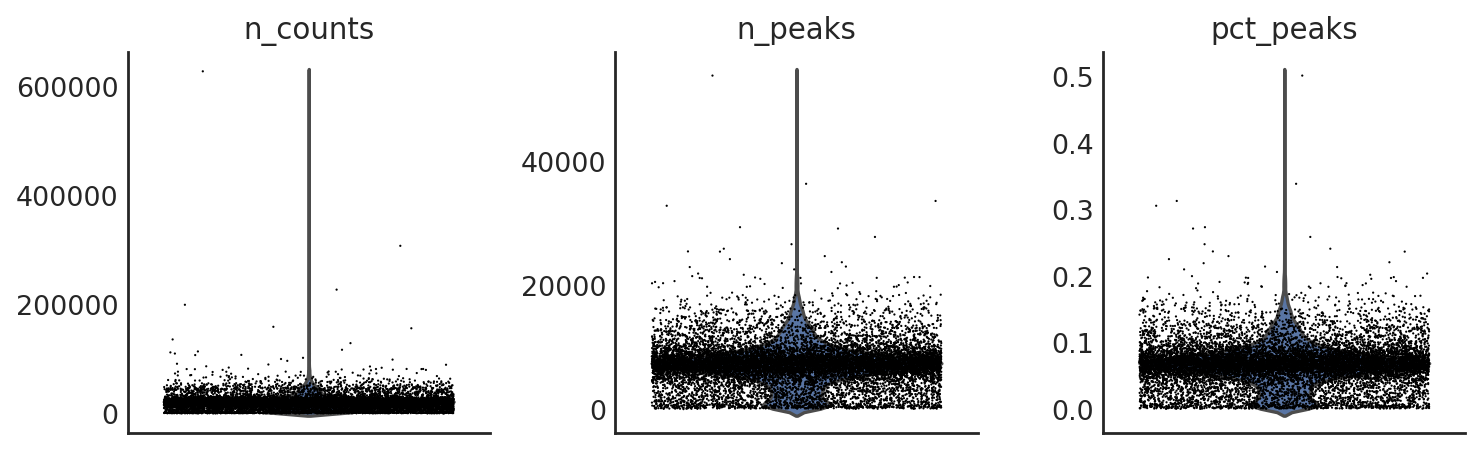

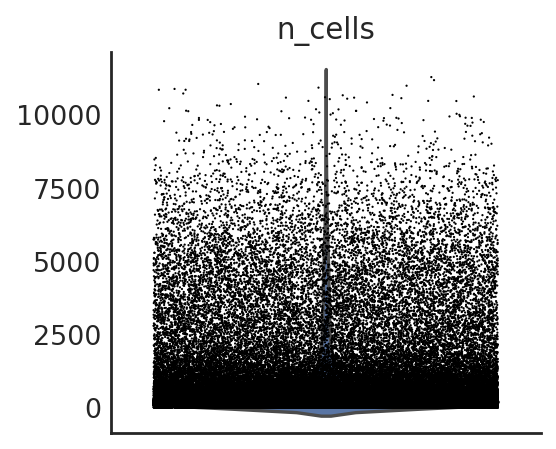

In [13]:
si.pl.violin(adata_CP,list_obs=['n_counts','n_peaks','pct_peaks'], list_var=['n_cells'])

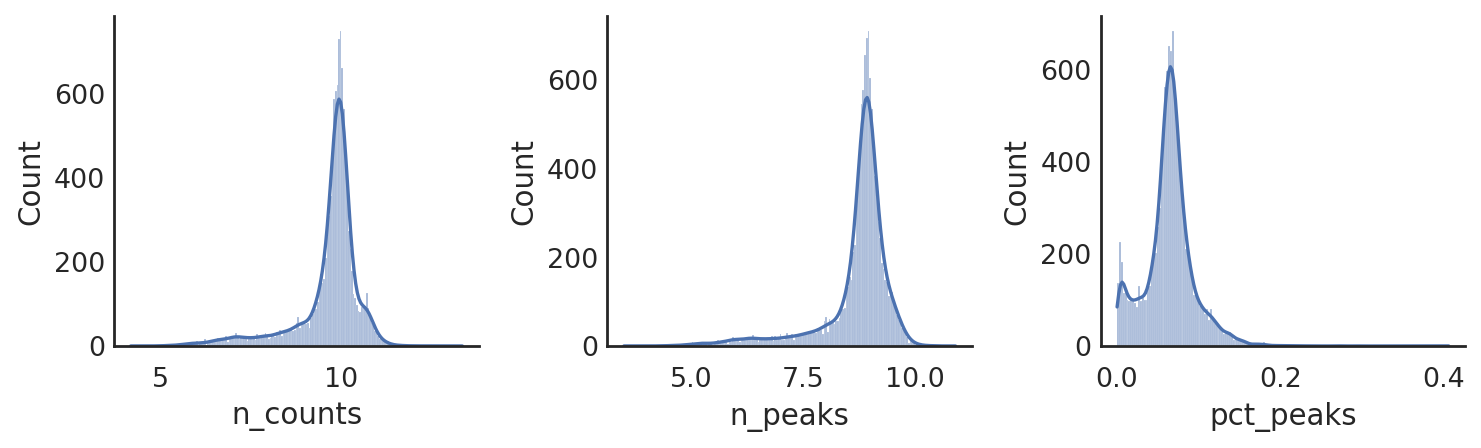

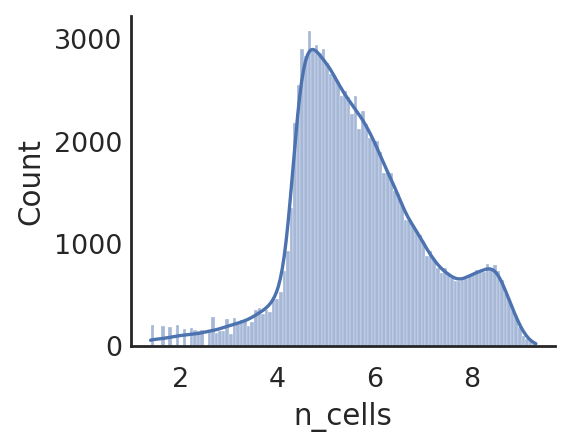

In [14]:
si.pl.hist(adata_CP,list_obs=['n_counts','n_peaks','pct_peaks'], log=True, list_var=['n_cells'])

Filter out cells if needed:

```python
si.pp.filter_cells_atac(adata_CP,min_n_peaks=100)
```

### select peaks (optional)

It will speed up the trainning process by only keeping peaks associated with top PCs

In [15]:
si.pp.pca(adata_CP, n_components=50)

the number of selected PC is: 50


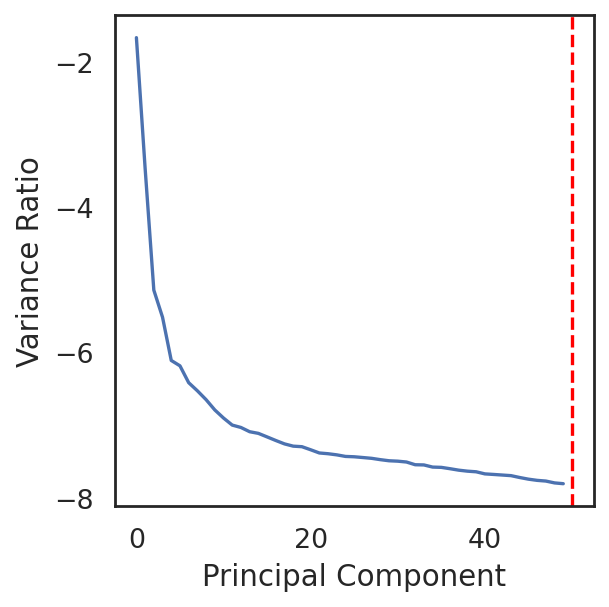

In [16]:
si.pl.pca_variance_ratio(adata_CP)

In [17]:
#The number of selected PCs can be further reduced based on the elbow plot
si.pp.select_pcs(adata_CP,n_pcs=40)

In [18]:
si.pp.select_pcs_features(adata_CP)

#features selected from PC 0: 18006
#features selected from PC 1: 17932
#features selected from PC 2: 17967
#features selected from PC 3: 17927
#features selected from PC 4: 18009
#features selected from PC 5: 17933
#features selected from PC 6: 17903
#features selected from PC 7: 17954
#features selected from PC 8: 17915
#features selected from PC 9: 17935
#features selected from PC 10: 17938
#features selected from PC 11: 17964
#features selected from PC 12: 17936
#features selected from PC 13: 17903
#features selected from PC 14: 17909
#features selected from PC 15: 17947
#features selected from PC 16: 17900
#features selected from PC 17: 17932
#features selected from PC 18: 18012
#features selected from PC 19: 17904
#features selected from PC 20: 17897
#features selected from PC 21: 17967
#features selected from PC 22: 17925
#features selected from PC 23: 17905
#features selected from PC 24: 17927
#features selected from PC 25: 17916
#features selected from PC 26: 17948
#features s

In [19]:
# si.pl.pcs_features(adata_CP, fig_size=(3,3))

## RNA-seq part

### preprocessing

In [20]:
si.pp.filter_genes(adata_CG,min_n_cells=3)

Before filtering: 
11909 cells, 36601 genes
Filter genes based on min_n_cells


/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/hc_simba/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


After filtering out low-expressed genes: 
11909 cells, 26349 genes


In [21]:
si.pp.cal_qc_rna(adata_CG)

In [22]:
si.pp.normalize(adata_CG,method='lib_size')

In [23]:
si.pp.log_transform(adata_CG)

In [24]:
si.pp.select_variable_genes(adata_CG, n_top_genes=4000)

4000 variable genes are selected.


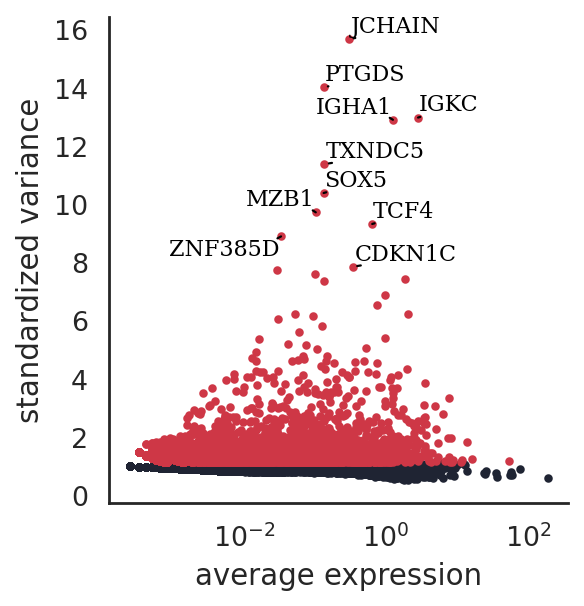

In [25]:
si.pl.variable_genes(adata_CG,show_texts=True)

### discretize RNA expression

In [26]:
si.tl.discretize(adata_CG,n_bins=5)

[0.10545505 1.1394415  1.6413939  2.2801738  3.348012   8.160636  ]


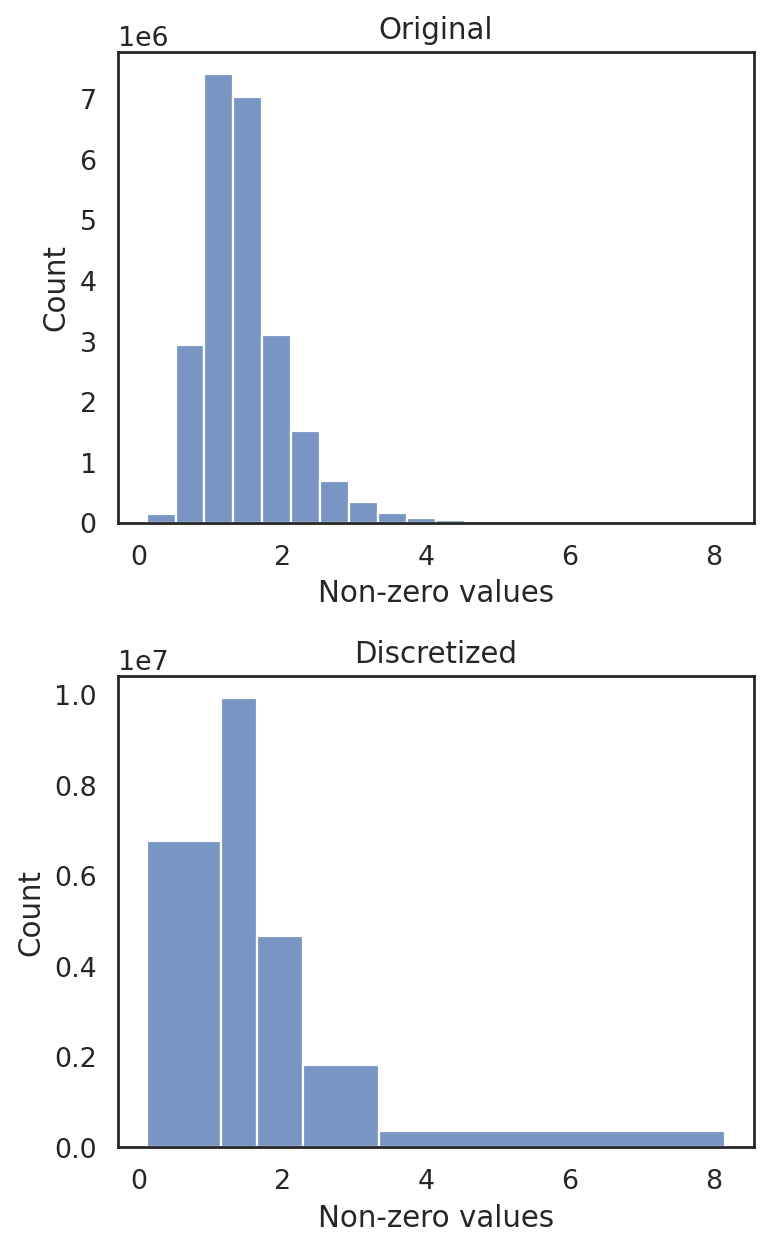

In [27]:
si.pl.discretize(adata_CG,kde=False)

### Infer edges between cells of different modalities

In [28]:
adata_CG_atac = si.tl.gene_scores(adata_CP,genome='hg38',use_gene_weigt=True, use_top_pcs=True)

Gene scores are being calculated for the first time
`use_precomputed` has been ignored


***** WARNING: File /tmp/pybedtools.g5f7se1e.tmp has inconsistent naming convention for record:
GL000194.1	101218	101619	61173

***** WARNING: File /tmp/pybedtools.g5f7se1e.tmp has inconsistent naming convention for record:
GL000194.1	101218	101619	61173

***** WARNING: File /tmp/pybedtools.g5f7se1e.tmp has inconsistent naming convention for record:
GL000194.1	101218	101619	61173

***** WARNING: File /tmp/pybedtools.g5f7se1e.tmp has inconsistent naming convention for record:
GL000194.1	101218	101619	61173



Processing: 0.0%
Processing: 20.0%
Processing: 40.0%
Processing: 60.0%


/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/hc_simba/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [29]:
si.pp.filter_genes(adata_CG_atac,min_n_cells=3)
si.pp.cal_qc_rna(adata_CG_atac)
si.pp.normalize(adata_CG_atac,method='lib_size')
si.pp.log_transform(adata_CG_atac)

Before filtering: 
11909 cells, 38824 genes
Filter genes based on min_n_cells
After filtering out low-expressed genes: 
11909 cells, 22786 genes


In [30]:
adata_CrnaCatac = si.tl.infer_edges(adata_CG, adata_CG_atac, n_components=15, k=15)

#shared features: 2713
Performing randomized SVD ...
Searching for mutual nearest neighbors ...
89680 edges are selected


In [32]:
adata_CrnaCatac

AnnData object with n_obs × n_vars = 11909 × 11909
    obs: 'celltype', 'n_counts', 'n_genes', 'pct_genes', 'pct_mt'
    var: 'celltype', 'n_counts', 'n_peaks', 'pct_peaks', 'n_genes', 'pct_genes', 'pct_mt'
    obsm: 'svd'
    varm: 'svd'
    layers: 'conn'

#selected edges: 89680


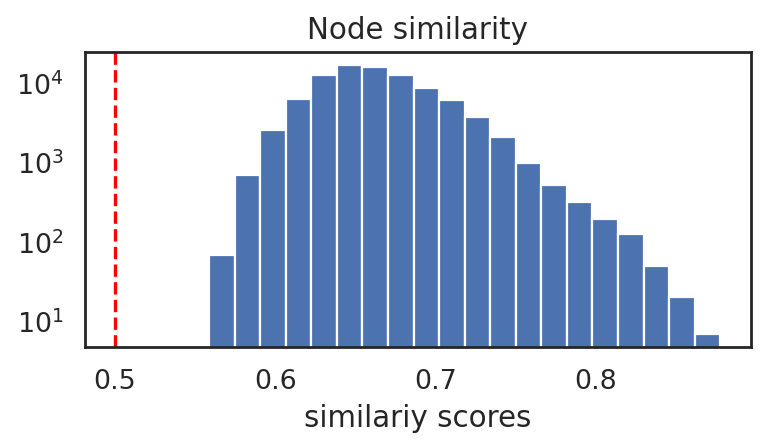

In [31]:
si.pl.node_similarity(adata_CrnaCatac,cutoff=0.5)

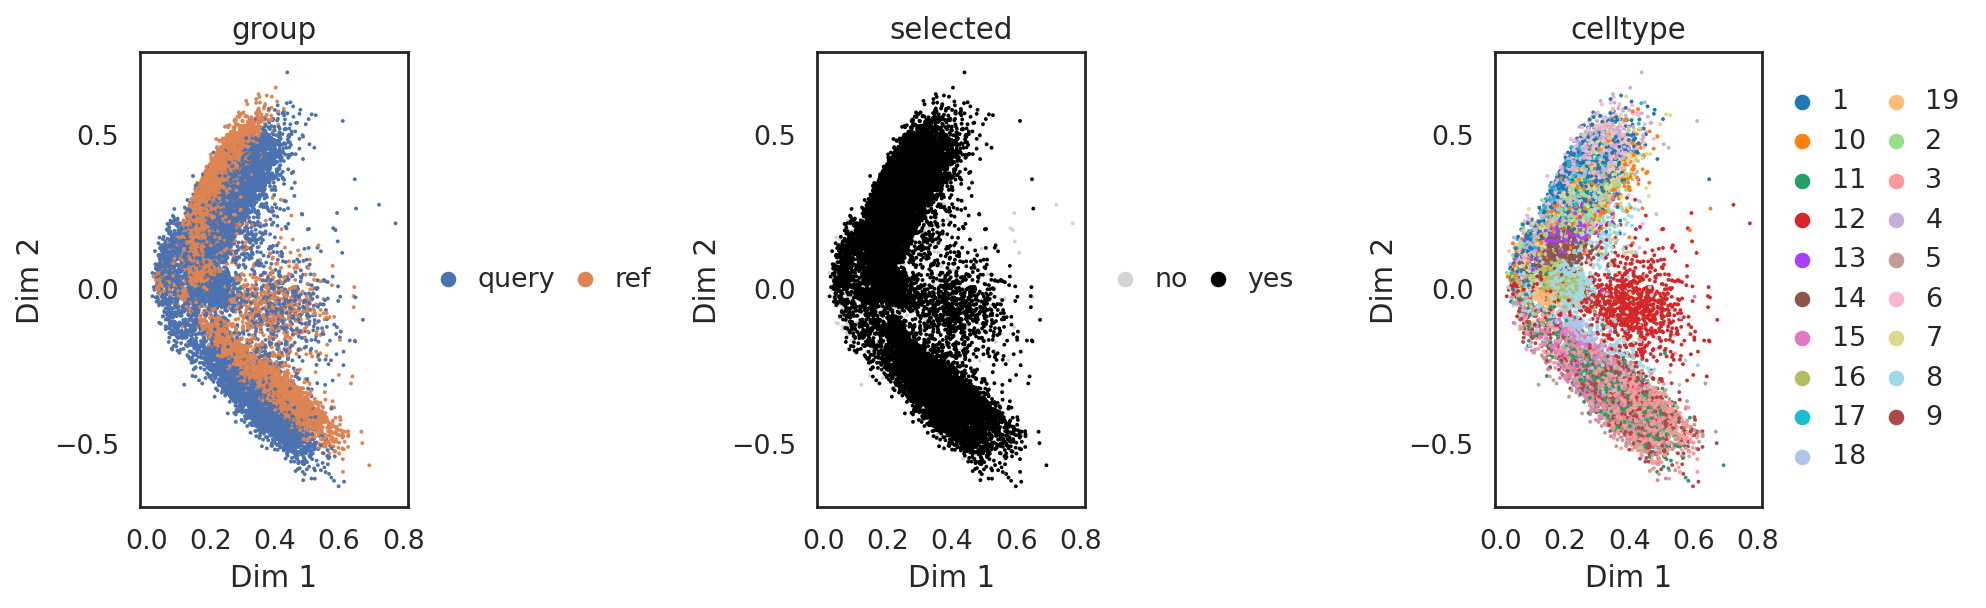

In [33]:
si.pl.svd_nodes(adata_CrnaCatac,
                color=['celltype'],
                size=3,
                cutoff=0.5,
                fig_legend_ncol=2)

In [34]:
# edges can be futhere trimmed if needed. Here we keep all of them
si.tl.trim_edges(adata_CrnaCatac, cutoff=0.5)

89680 edges are selected


### generate Graph

In [35]:
si.tl.gen_graph(list_CP=[adata_CP],
                list_CG=[adata_CG],
                list_CC=[adata_CrnaCatac],
                copy=False,
                use_highly_variable=True,
                use_top_pcs=True,
                dirname='graph0')

/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/hc_simba/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


relation0: source: C, destination: P
#edges: 79782752
relation1: source: C2, destination: G
#edges: 967473
relation2: source: C2, destination: G
#edges: 1488857
relation3: source: C2, destination: G
#edges: 968440
relation4: source: C2, destination: G
#edges: 544749
relation5: source: C2, destination: G
#edges: 104139
relation6: source: C2, destination: C
#edges: 89680
Total number of edges: 83946090
Writing graph file "pbg_graph.txt" to "multiome_10xpmbc10k_integration/pbg/graph0" ...
Finished.


### PBG training

Before PBG training, let’s take a look at the parameters:

In [36]:
si.settings.pbg_params

{'entity_path': 'multiome_10xpmbc10k_integration/pbg/graph0/input/entity',
 'edge_paths': ['multiome_10xpmbc10k_integration/pbg/graph0/input/edge'],
 'checkpoint_path': '',
 'entities': {'C': {'num_partitions': 1},
  'C2': {'num_partitions': 1},
  'G': {'num_partitions': 1},
  'P': {'num_partitions': 1}},
 'relations': [{'name': 'r0',
   'lhs': 'C',
   'rhs': 'P',
   'operator': 'none',
   'weight': 1.0},
  {'name': 'r1', 'lhs': 'C2', 'rhs': 'G', 'operator': 'none', 'weight': 1.0},
  {'name': 'r2', 'lhs': 'C2', 'rhs': 'G', 'operator': 'none', 'weight': 2.0},
  {'name': 'r3', 'lhs': 'C2', 'rhs': 'G', 'operator': 'none', 'weight': 3.0},
  {'name': 'r4', 'lhs': 'C2', 'rhs': 'G', 'operator': 'none', 'weight': 4.0},
  {'name': 'r5', 'lhs': 'C2', 'rhs': 'G', 'operator': 'none', 'weight': 5.0},
  {'name': 'r6', 'lhs': 'C2', 'rhs': 'C', 'operator': 'none', 'weight': 10.0}],
 'dynamic_relations': False,
 'dimension': 50,
 'global_emb': False,
 'comparator': 'dot',
 'num_epochs': 10,
 'workers':

If no parameters need to be adjusted, the training can be simply done with:

```python
si.tl.pbg_train(auto_wd=True, save_wd=True, output='model')
```

Here we show how to adjust training-related parameters if needed. In general, weight decay `wd` is the only parameter that might need to be adjusted based on the following pbg metric plots. However, in almost all the cases, the automatically decided `wd` (enabling it by setting `auto_wd=True`) works well.

E.g. we want to change the number of cpus `workers`:

In [37]:
# modify parameters
dict_config = si.settings.pbg_params.copy()
# dict_config['wd'] = 0.000282
dict_config['workers'] = 12

## start training
si.tl.pbg_train(pbg_params = dict_config, auto_wd=True, save_wd=True, output='model')

Auto-estimated weight decay is 0.000282
`.settings.pbg_params['wd']` has been updated to 0.000282
Converting input data ...
[2021-06-29 18:08:26.269771] Found some files that indicate that the input data has already been preprocessed, not doing it again.
[2021-06-29 18:08:26.270171] These files are in: multiome_10xpmbc10k_integration/pbg/graph0/input/entity, multiome_10xpmbc10k_integration/pbg/graph0/input/edge
Starting training ...
Finished


> If `wd` is specified by users instead of being automatically decided, then make sure to update it in simba setting:
```python
si.settings.pbg_params = dict_config.copy()
```

The trained result can be loaded in with the following steps:

By default, it's using the current training result stored in `.setting.pbg_params`
```python
# load in graph ('graph0') info
si.load_graph_stats()
# load in model info for ('graph0')
si.load_pbg_config()
```
Users can also specify different pathss
```python
# load in graph ('graph0') info
si.load_graph_stats(path='./multiome_10xpmbc10k_integration/pbg/graph0/')
# load in model info for ('graph0')
si.load_pbg_config(path='./multiome_10xpmbc10k_integration/pbg/graph0/model/')
```

Plotting training metrics to make sure the model is not overfitting

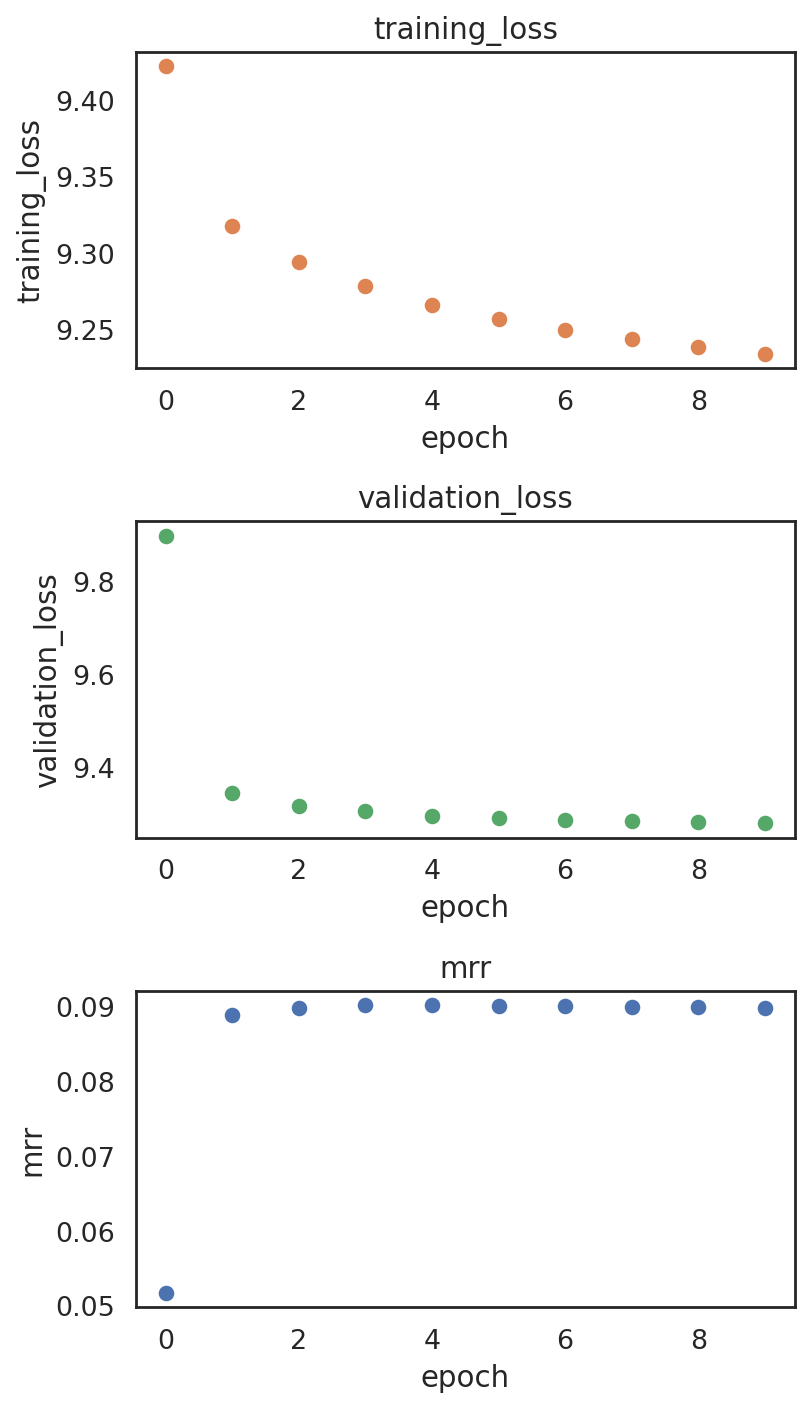

In [38]:
si.pl.pbg_metrics(fig_ncol=1)

## Post-training Analysis

In [52]:
dict_adata = si.read_embedding()

In [53]:
dict_adata

{'C': AnnData object with n_obs × n_vars = 11909 × 50,
 'C2': AnnData object with n_obs × n_vars = 11909 × 50,
 'G': AnnData object with n_obs × n_vars = 4000 × 50,
 'P': AnnData object with n_obs × n_vars = 61189 × 50}

In [54]:
adata_C = dict_adata['C']  # embeddings for ATACseq cells 
adata_C2 = dict_adata['C2']  # embeddings for RNAseq cells
adata_G = dict_adata['G']  # embeddings for genes
adata_P = dict_adata['P']  # embeddings for peaks

In [55]:
adata_C

AnnData object with n_obs × n_vars = 11909 × 50

In [56]:
adata_C2

AnnData object with n_obs × n_vars = 11909 × 50

In [57]:
adata_G

AnnData object with n_obs × n_vars = 4000 × 50

In [58]:
adata_P

AnnData object with n_obs × n_vars = 61189 × 50

In [59]:
adata_CP.obs['celltype'] = adata_CP.obs['celltype'].astype(str)
adata_CG.obs['celltype'] = adata_CG.obs['celltype'].astype(str)

import seaborn as sns
import numpy as np
pal = sns.color_palette('deep', 10).as_hex() + sns.color_palette('pastel', 10).as_hex()
palette_celltype={x:pal[i] for i,x in enumerate(np.arange(1,20).astype(str))}

visualize embeddings of ATAC-seq cells

In [60]:
## Add annotation of celltypes (optional)
adata_C.obs['celltype'] = adata_CP[adata_C.obs_names,:].obs['celltype'].copy()
adata_C

/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/hc_simba/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


AnnData object with n_obs × n_vars = 11909 × 50
    obs: 'celltype'

In [61]:
si.tl.umap(adata_C,n_neighbors=15,n_components=2)

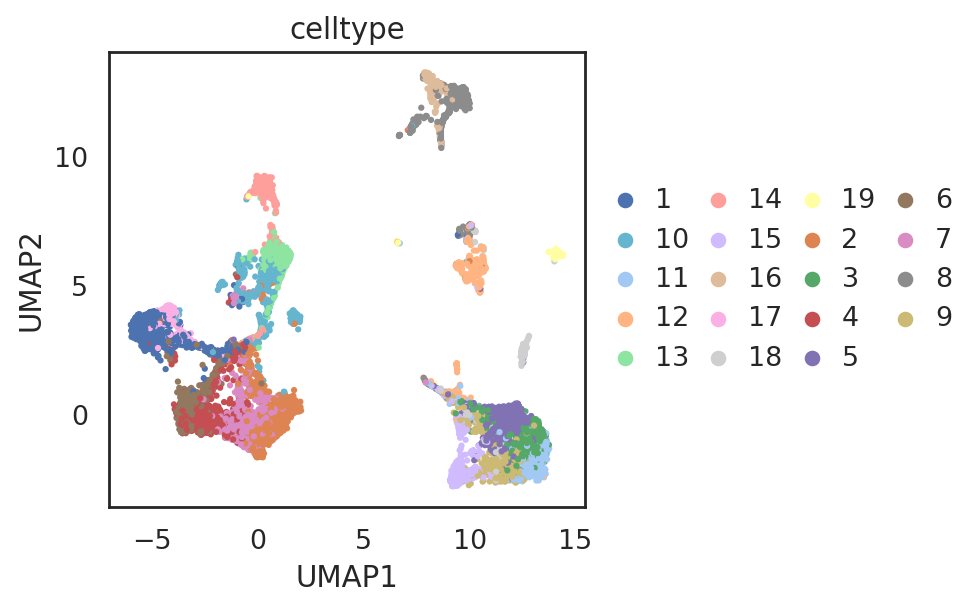

In [63]:
si.pl.umap(adata_C,
           color=['celltype'],
           dict_palette={'celltype': palette_celltype},
           drawing_order='random',
           fig_size=(6,4),
           fig_legend_ncol=4)

visualize embeddings of RNA-seq cells

In [64]:
## Add annotation of celltypes (optional)
adata_C2.obs['celltype'] = adata_CG[adata_C2.obs_names,:].obs['celltype'].copy()
adata_C2

/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/hc_simba/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


AnnData object with n_obs × n_vars = 11909 × 50
    obs: 'celltype'

In [65]:
si.tl.umap(adata_C2,n_neighbors=15,n_components=2)

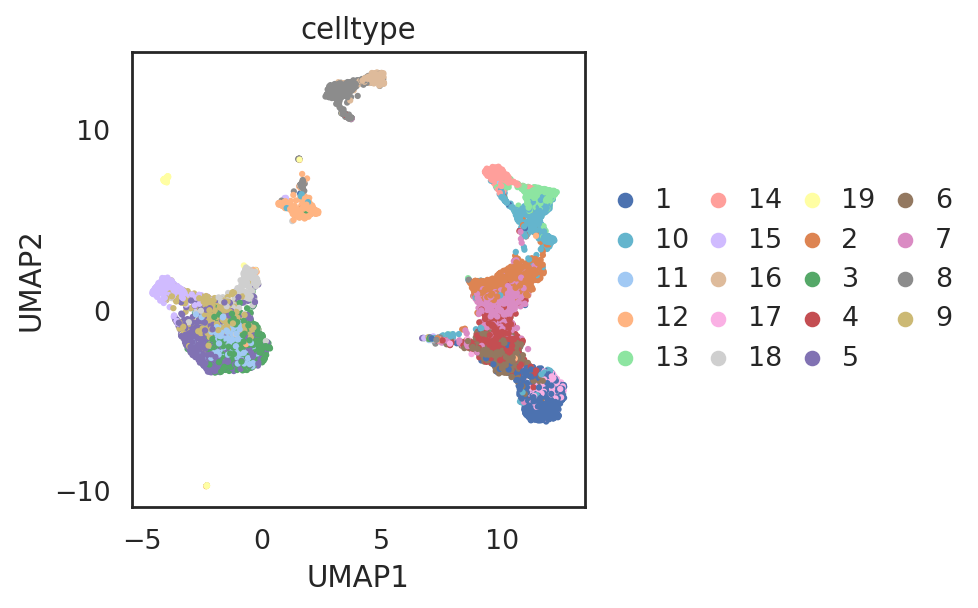

In [66]:
si.pl.umap(adata_C2,
           color=['celltype'],
           dict_palette={'celltype': palette_celltype},
           drawing_order='random',
           fig_size=(6,4),
           fig_legend_ncol=4)

visualize embeddings of both ATACseq cells and RNAseq cells (RNAseq cells are used as the reference)

In [67]:
adata_all = si.tl.embed(adata_ref=adata_C2,
                        list_adata_query=[adata_C],
                        use_precomputed=False)

Performing softmax transformation for query data 0;


In [68]:
## add annotations of cells
adata_all.obs['entity_group'] = ""
adata_all.obs.loc[adata_C.obs_names, 'entity_group'] = "ATAC-seq"
adata_all.obs.loc[adata_C2.obs_names, 'entity_group'] = "RNA-seq"
adata_all.obs.head()

,celltype,id_dataset,entity_group
CCCAAATAGCCTGTTC-1_rna,5,ref,RNA-seq
TCAAGGAAGCAGCTCA-1_rna,9,ref,RNA-seq
AAAGGCTCACAGCCAT-1_rna,2,ref,RNA-seq
TATAGCTCACCTGCCT-1_rna,3,ref,RNA-seq
CGATTTGCACCTACTT-1_rna,12,ref,RNA-seq


In [69]:
si.tl.umap(adata_all,n_neighbors=15,n_components=2)

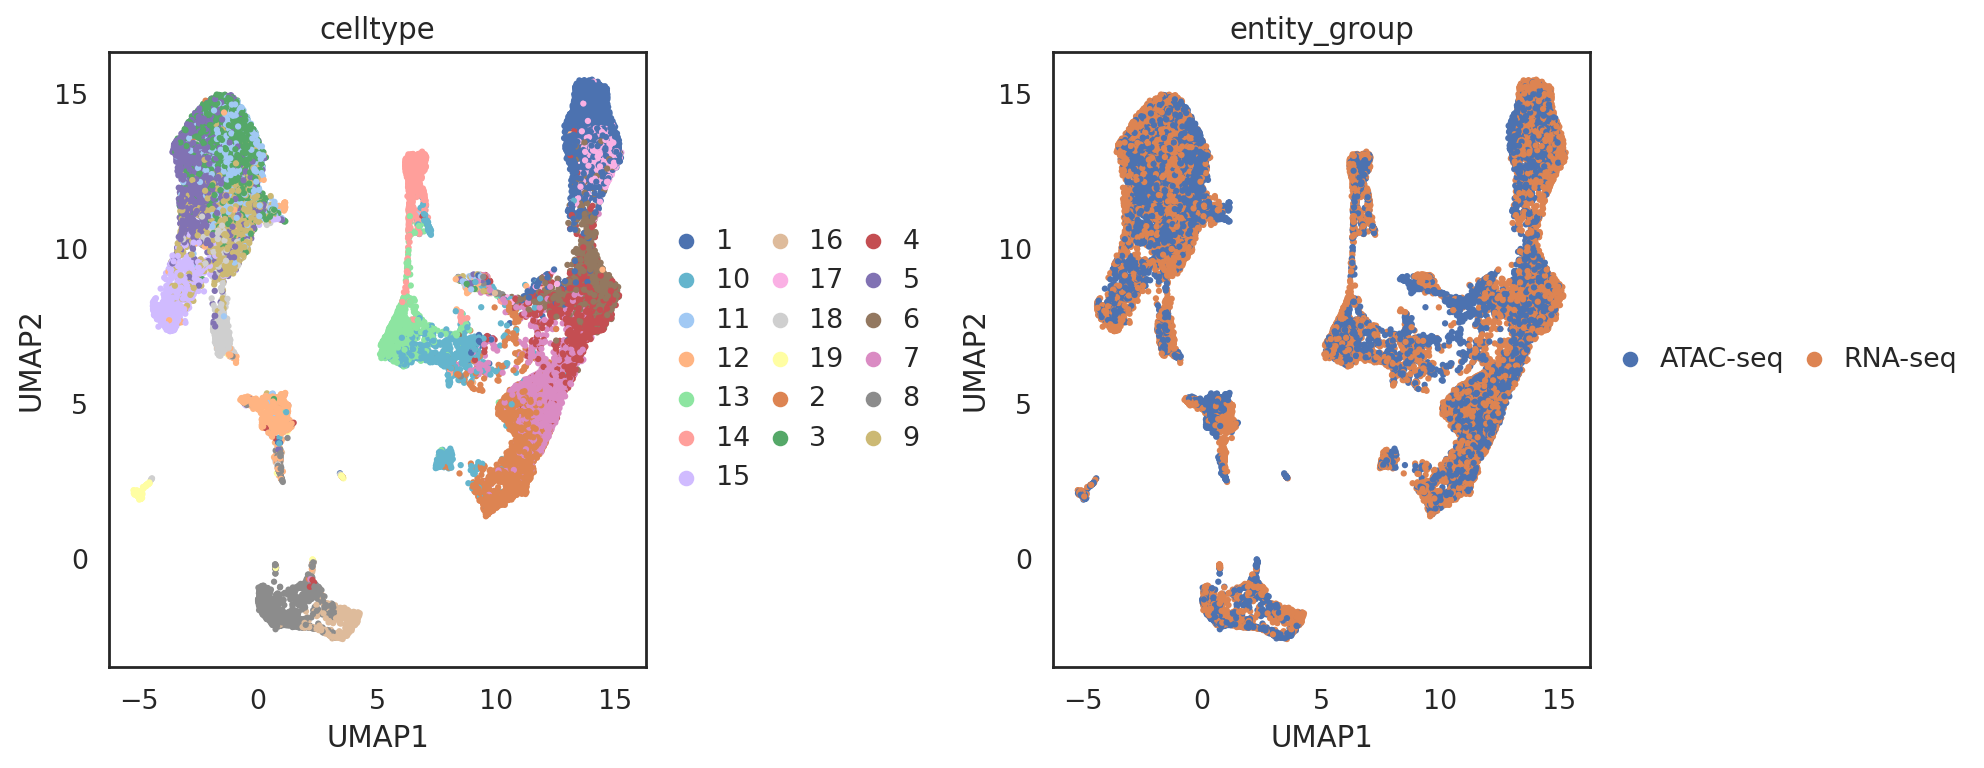

In [71]:
si.pl.umap(adata_all,
           color=['celltype', 'entity_group'],
           dict_palette={'celltype': palette_celltype},
           drawing_order='random',
           fig_size=(6,5),
           fig_legend_ncol=3)

visualize embeddings of both ATACseq cells and RNAseq cells (ATACseq cells are used as the reference)

In [72]:
adata_all2 = si.tl.embed(adata_ref=adata_C,
                        list_adata_query=[adata_C2])

Performing softmax transformation for query data 0;


In [73]:
## add annotations of cells and genes
adata_all2.obs['entity_group'] = ""
adata_all2.obs.loc[adata_C.obs_names, 'entity_group'] = "ATAC-seq"
adata_all2.obs.loc[adata_C2.obs_names, 'entity_group'] = "RNA-seq"
adata_all2.obs.head()

,celltype,id_dataset,entity_group
GAGTAACCAGTTTGGC-1_atac,2,ref,ATAC-seq
TTGTCCATCCCTGATC-1_atac,12,ref,ATAC-seq
TTTCGTCCATGTGGGA-1_atac,14,ref,ATAC-seq
GCCTTTATCGTGCTTC-1_atac,13,ref,ATAC-seq
AGCACTAGTCACCTAT-1_atac,1,ref,ATAC-seq


In [74]:
si.tl.umap(adata_all2,n_neighbors=15,n_components=2)

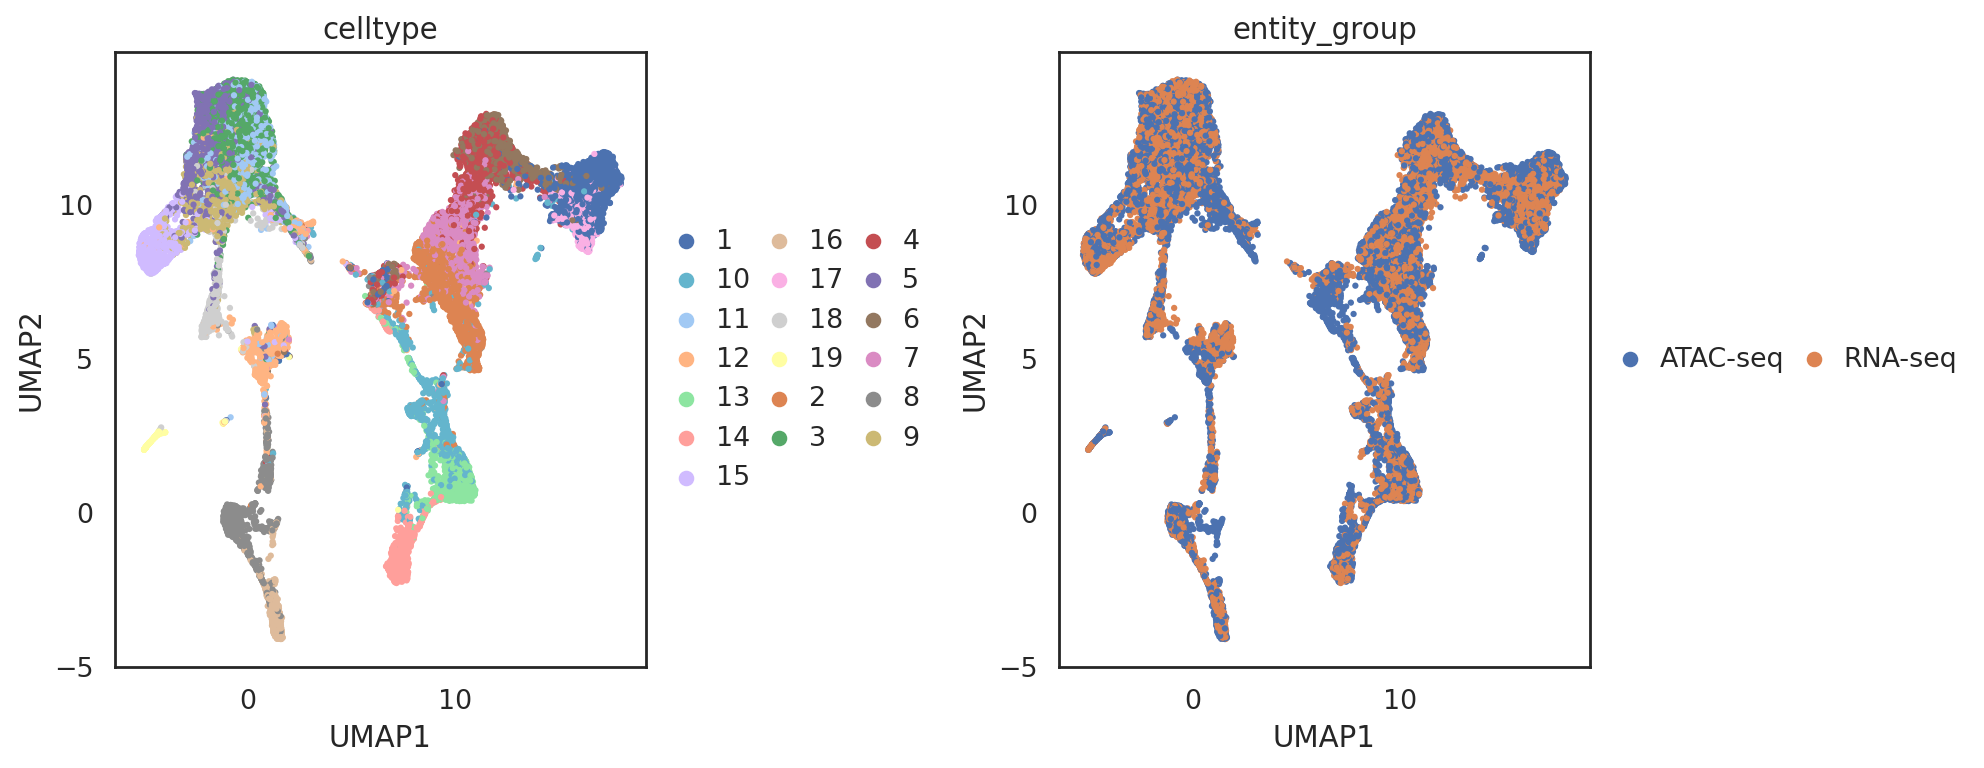

In [75]:
si.pl.umap(adata_all2,
           color=['celltype', 'entity_group'],
           dict_palette={'celltype': palette_celltype},
           drawing_order='random',
           fig_size=(6,5),
           fig_legend_ncol=3)

visualize embeddings of cells (both RNA-seq and ATAC-seq), genes, and peaks

In [76]:
adata_all_CGP = si.tl.embed(adata_ref=adata_C2,
                            list_adata_query=[adata_C, adata_G, adata_P],
                            use_precomputed=False)

Performing softmax transformation for query data 0;
Performing softmax transformation for query data 1;
Performing softmax transformation for query data 2;


In [77]:
# add annotations for all entities
adata_all_CGP.obs['entity_anno'] = ""
adata_all_CGP.obs.loc[adata_C.obs_names, 'entity_anno'] = adata_all_CGP.obs.loc[adata_C.obs_names, 'celltype'].tolist()
adata_all_CGP.obs.loc[adata_C2.obs_names, 'entity_anno'] = adata_all_CGP.obs.loc[adata_C2.obs_names, 'celltype'].tolist()
adata_all_CGP.obs.loc[adata_G.obs_names, 'entity_anno'] = 'gene'
adata_all_CGP.obs.loc[adata_P.obs_names, 'entity_anno'] = 'peak'

In [78]:
# select cell-type specific peaks
adata_cmp_CP = si.tl.compare_entities(adata_ref=adata_C2, adata_query=adata_P)
peaks_selected = adata_cmp_CP.var_names[(adata_cmp_CP.var['max']>1.5) & (adata_cmp_CP.var['gini']>0.35)].tolist()
len(peaks_selected)

19597

In [79]:
# keep only cell-type specific peaks
adata_all_CGP_sub = adata_all_CGP[adata_C.obs_names.tolist() + 
                                  adata_C2.obs_names.tolist() +
                                  adata_G.obs_names.tolist() + 
                                  peaks_selected, :].copy()

In [80]:
si.tl.umap(adata_all_CGP_sub,n_neighbors=15,n_components=2)

In [82]:
palette_entity_anno = palette_celltype.copy()
palette_entity_anno['gene'] = "#607e95"
palette_entity_anno['peak'] = "#e5c2c8"

Trying to set attribute `.uns` of view, copying.


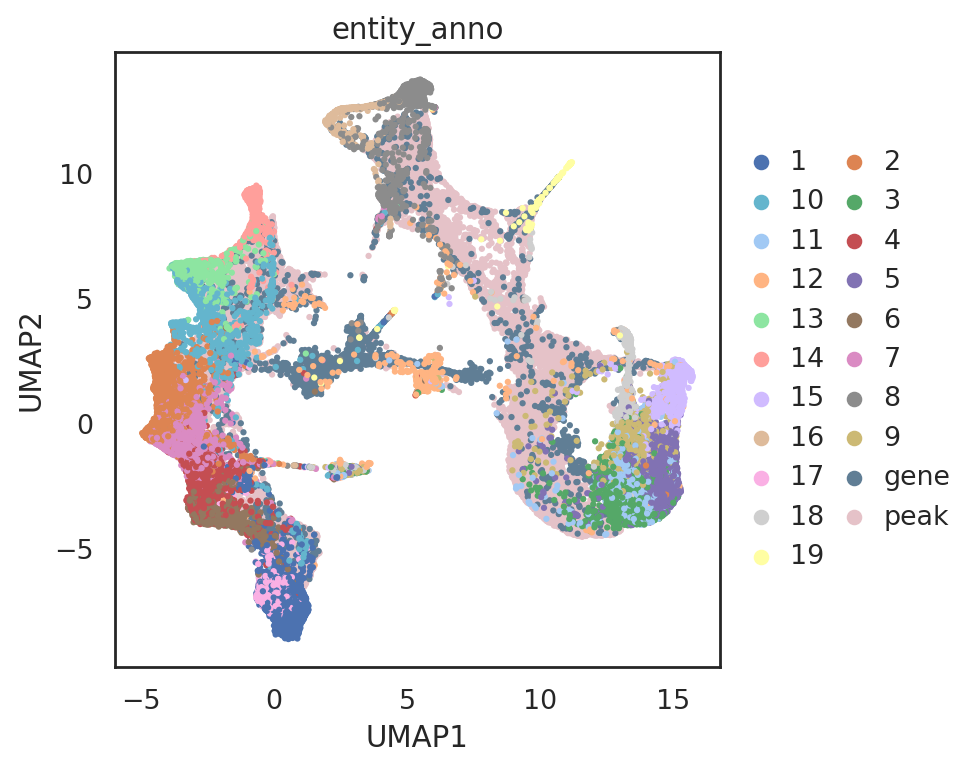

In [83]:
si.pl.umap(adata_all_CGP_sub[::-1,],
           color=['entity_anno'],
           dict_palette={'entity_anno': palette_entity_anno},
           drawing_order='original',
           fig_legend_ncol=2,
           fig_size=(6,5))

In [86]:
# find neighbor genes of given pins
query_genes = si.tl.query(adata_all_CGP_sub,
                          pin=np.array([[0.2, -8],[15.0, 2.0]]),
                          use_radius=False,
                          k=5,
                          obsm='X_umap',
                          anno_filter='entity_anno',
                          filters=['gene'])
print(query_genes.shape)
query_genes.head()

(10, 5)


,celltype,id_dataset,entity_anno,distance,query
KCNMA1,NaN,query_1,gene,0.223033,1
S100B,NaN,query_1,gene,0.235300,0
SLC18A1,NaN,query_1,gene,0.307673,1
CASP5,NaN,query_1,gene,0.357289,1
MS4A7,NaN,query_1,gene,0.358432,1


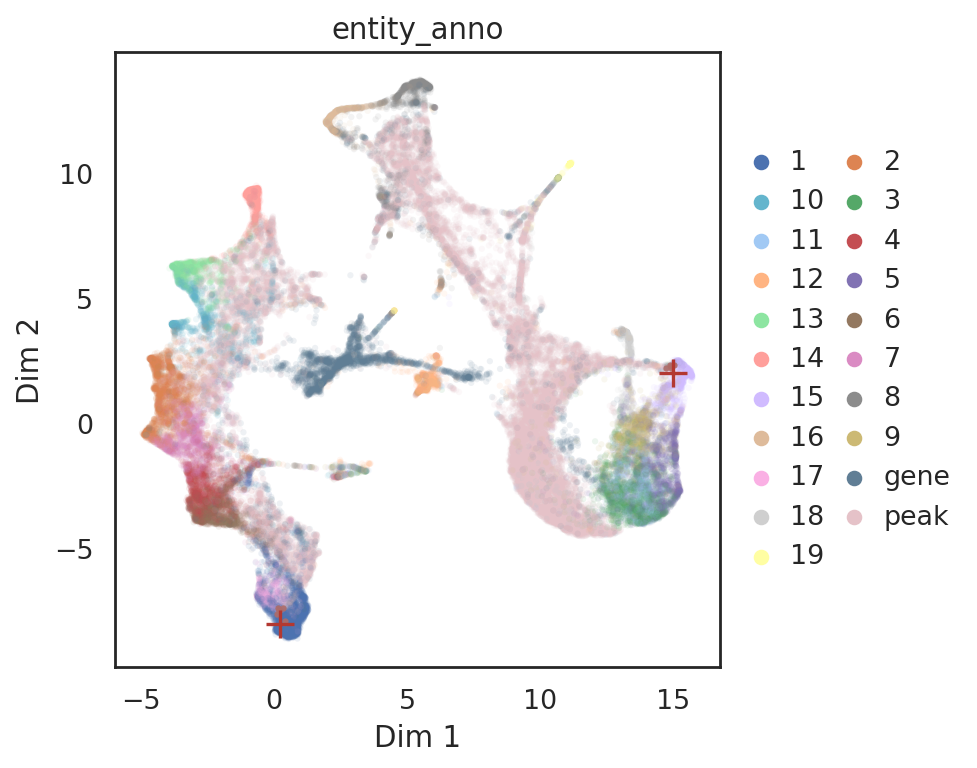

In [87]:
# show locations of pin points and its neighbor genes 
si.pl.query(adata_all_CGP_sub,
            show_texts=False, 
            color=['entity_anno'], dict_palette={'entity_anno': palette_entity_anno},
            alpha=0.9,
            alpha_bg=0.1,
            fig_legend_ncol=2,
            fig_size=(6,5))

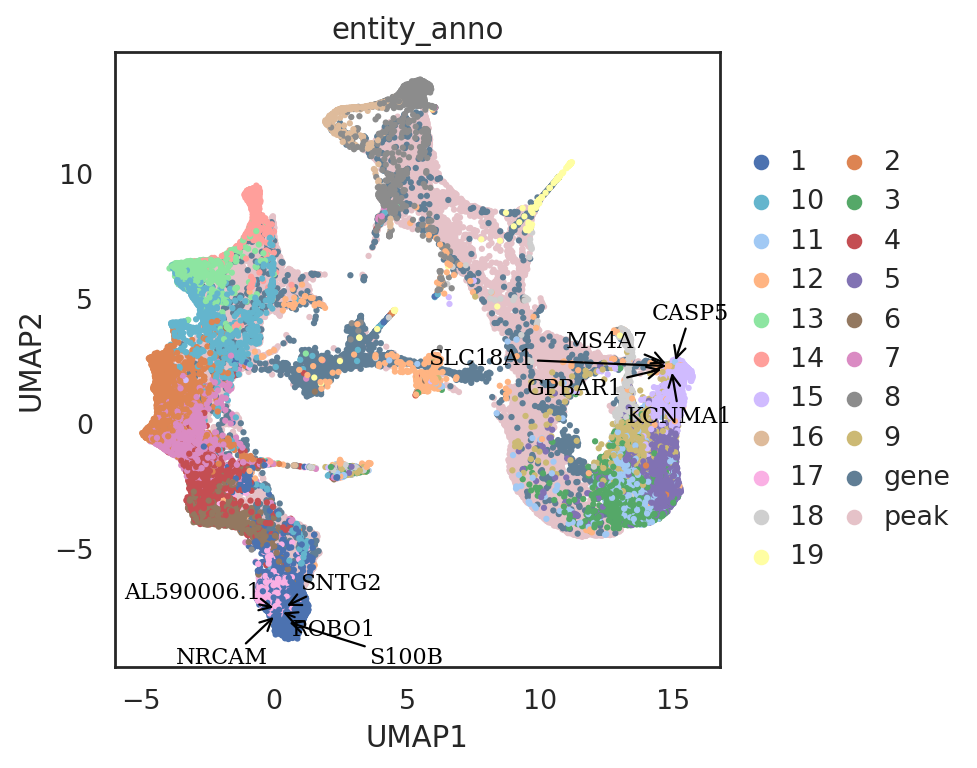

In [90]:
si.pl.umap(adata_all_CGP_sub[::-1],
           color=['entity_anno'],
           dict_palette={'entity_anno': palette_entity_anno},
           drawing_order='original',
           show_texts=True,
           texts=query_genes.index,
           text_expand=(1.2,1.4),
           fig_size=(6,5),
           fig_legend_ncol=2)

### save results

In [91]:
adata_CP.write(os.path.join(workdir, 'adata_CP.h5ad'))
adata_CG.write(os.path.join(workdir, 'adata_CG.h5ad'))
adata_CG_atac.write(os.path.join(workdir, 'adata_CG_atac.h5ad'))
adata_CrnaCatac.write(os.path.join(workdir, 'adata_CrnaCatac.h5ad'))

adata_C.write(os.path.join(workdir, 'adata_C.h5ad'))
adata_C2.write(os.path.join(workdir, 'adata_C2.h5ad'))
adata_G.write(os.path.join(workdir, 'adata_G.h5ad'))
adata_P.write(os.path.join(workdir, 'adata_P.h5ad'))

adata_all.write(os.path.join(workdir, 'adata_all.h5ad'))
adata_all2.write(os.path.join(workdir, 'adata_all2.h5ad'))
adata_all_CGP.write(os.path.join(workdir, 'adata_all_CGP.h5ad'))

... storing 'celltype' as categorical
... storing 'pbg_id' as categorical
... storing 'celltype' as categorical
... storing 'pbg_id' as categorical
... storing 'chr' as categorical
... storing 'strand' as categorical
... storing 'celltype' as categorical
... storing 'celltype' as categorical
... storing 'celltype' as categorical
... storing 'id_dataset' as categorical
... storing 'entity_group' as categorical
... storing 'celltype' as categorical
... storing 'id_dataset' as categorical
... storing 'entity_group' as categorical
... storing 'celltype' as categorical
... storing 'id_dataset' as categorical
... storing 'entity_anno' as categorical


Read back anndata objects

```python
adata_CP = si.read_h5ad(os.path.join(workdir, 'adata_CP.h5ad'))
adata_CG = si.read_h5ad(os.path.join(workdir, 'adata_CG.h5ad'))
adata_CG_atac = si.read_h5ad(os.path.join(workdir, 'adata_CG_atac.h5ad'))
adata_CrnaCatac = si.read_h5ad(os.path.join(workdir, 'adata_CrnaCatac.h5ad'))

adata_C = si.read_h5ad(os.path.join(workdir, 'adata_C.h5ad'))
adata_C2 = si.read_h5ad(os.path.join(workdir, 'adata_C2.h5ad'))
adata_G = si.read_h5ad(os.path.join(workdir, 'adata_G.h5ad'))
adata_P = si.read_h5ad(os.path.join(workdir, 'adata_P.h5ad'))

adata_all = si.read_h5ad(os.path.join(workdir, 'adata_all.h5ad'))
adata_all2 = si.read_h5ad(os.path.join(workdir, 'adata_all2.h5ad'))
adata_all_CGP = si.read_h5ad(os.path.join(workdir, 'adata_all_CGP.h5ad'))
```